In [51]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Conv1D, Dropout, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.optimizers import Adam

<h1>Boite à outils</h1>

In [52]:
def showWordCloud(textData):
    wordcloud = WordCloud(max_words=100, background_color="white", min_font_size=10).generate(textData)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    cm = cm.astype("float") / cm.sum(axis=1)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, fontsize=20, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i,j] > 0.5 else "black"        
        plt.text(j, i, format(cm[i, j], ".2f"), horizontalalignment="center", verticalalignment="center", color=color, fontsize=40)

    plt.ylabel("Correction", fontsize=15)
    plt.xlabel("Prédiction", fontsize=15)

In [53]:
stopWords = set(stopwords.words("english"))
stopWords.add("NaN")

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–"}
    res = str(text)
    if res != None:
        for elm in forbidden:
            res = res.replace(elm, "")
        res = res.split()
        cleaned = []
        for word in res:
            if not word in stopWords:
                cleaned.append(word)
        res = " ".join(cleaned)
    return res

<h1>Traitement des données</h1>

<h2>Dataset n°1</h2>

<h3>Chargement des données</h3>

In [54]:
#https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
real_news1 = pd.read_csv("./dataset1/True.csv")
fake_news1 = pd.read_csv("./dataset1/Fake.csv")
real_news1["label"] = 0
fake_news1["label"] = 1

dataframe1 = pd.concat([real_news1, fake_news1])
dataframe1["text"] = dataframe1["title"] + dataframe1["text"] 
del dataframe1["title"]
del dataframe1["subject"]
del dataframe1["date"]

dataframe1["text"] = dataframe1["text"].apply(cleanText)

dataframe1.sample(10)

,text,label
19792,Nepal holds final round municipal polls ethnic...,0
14900,SNIVELING COWARDS AT CNN Caught Editing Trump ...,1
8885,Watch Maine Governors Racist Rant For Yourself...,1
2964,US Press Corps Breaks Silence Drops MAJOR Bomb...,1
8124,Polling places become battleground US voting r...,0
20848,EU refugee court ruling triggers new eastwest ...,0
17977,UK border guard arrested France drugs firearms...,0
907,US lawmakers reach agreement new North Korea s...,0
18017,Rajoy Spain divided national unity preservedBE...,0
10833,CA STATE LEGISLATORS Want Traffic Fines To Be ...,1


<h3>Visualisation des mots des vraies infos</h3>

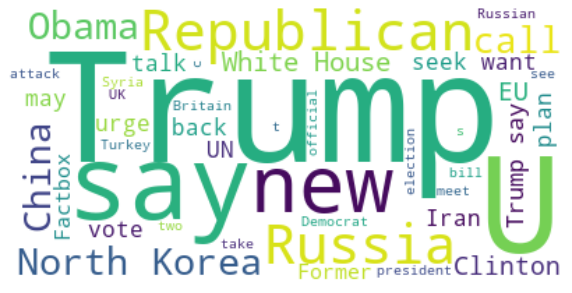

In [55]:
titles1_real = dataframe1["text"][dataframe1["label"] == 0].to_string(index=False)
showWordCloud(titles1_real)

<h3>Visualisation des mots des fausses infos</h3>

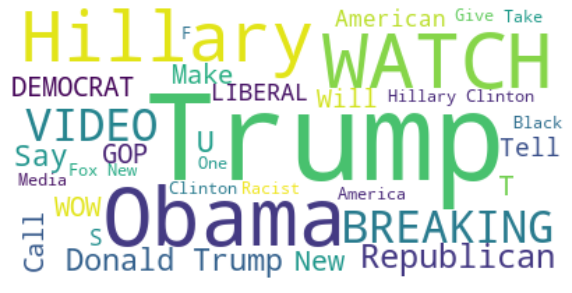

In [56]:
titles1_fake = dataframe1["text"][dataframe1["label"] == 1].to_string(index=False)
showWordCloud(titles1_fake)

<h2>Dataset n°2</h2>

<h3>Chargement des données</h3>

In [57]:
#https://www.kaggle.com/c/fake-news/data
dataframe2 = pd.read_csv("./dataset2/train.csv")
dataframe2["text"] = dataframe2["title"] + dataframe2["text"]
del dataframe2["id"]
del dataframe2["author"]
del dataframe2["title"]

dataframe2["text"] = dataframe2["text"].apply(cleanText)

dataframe2.sample(10)

,text,label
9188,AntiTrump Jewish Rally Refugees Organizer Fund...,0
184,WHO cancer agency fire withholding carcinogeni...,1
13758,How Americas Elections Are Hacked Missing Link...,1
1197,NGOs condemn terrorists Syria Russia fighting ...,1
4207,People benefits receive award outstanding cont...,1
2403,Another US Massacre AfghanistanWritten Jacob G...,1
1036,PHOTOS Latin America Condemns Venezuelas Exces...,0
2995,Julian Assange When You Read Newspaper Article...,0
4951,Blatant bias Trump may hasten end mainstream m...,1
2948,Ahead Trump Presidency Global Investors Sell B...,0


<h3>Visualisation des mots des vraies infos</h3>

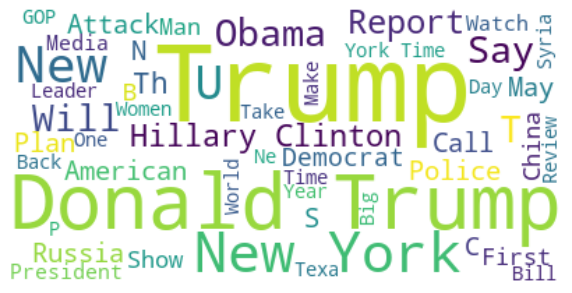

In [58]:
titles2_real = dataframe2["text"][dataframe2["label"] == 0].to_string(index=False)
showWordCloud(titles2_real)

<h3>Visualisation des mots des fausses informations</h3>

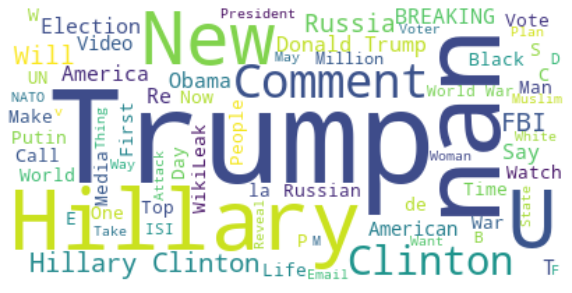

In [59]:
titles2_fake = dataframe2["text"][dataframe2["label"] == 1].to_string(index=False)
showWordCloud(titles2_fake)

<h1>It's machine learning time !</h1>

In [60]:
# on sépare les données en données d'entraînement et données de test (75% et 25%)
x_train, x_test, y_train, y_test = train_test_split(dataframe1["text"], dataframe1["label"], test_size=0.80, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 8979
Données de test : 35919


In [61]:
max_features = 10000 # taille max du vocab
maxlen = 60 # taille max de séquence

In [62]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(pd.concat([dataframe1["text"], dataframe2["text"]]))

In [63]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)

In [64]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)

<h2>Modèle de Détection (DCNN)</h2>

In [65]:
input_layer = Input((maxlen,))
x = Embedding(max_features, output_dim=512, input_length=maxlen, trainable=True)(input_layer)

x = Conv1D(128, 3, padding="same", activation="relu")(x)
x = Dropout(.1)(x)
x = MaxPooling1D()(x)

x = Conv1D(64, 3, padding="same", activation="relu")(x)
#x = Dropout(.1)(x)
x = MaxPooling1D()(x)

x = Conv1D(32, 3, padding="same", activation="relu")(x)
#x = Dropout(.1)(x)
x = MaxPooling1D()(x)

x = Flatten()(x)

output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 512)           5120000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 60, 128)           196736    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 30, 64)            24640     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 15, 64)            0   

In [66]:
progress = model.fit(x_train, y_train, batch_size=4096, epochs=15) 
""", validation_data=(x_test, y_test)"""

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
8979/8979 [==============================] - 1s 77us/step - loss: 0.6902 - accuracy: 0.5733
Epoch 2/15
8979/8979 [==============================] - 0s 34us/step - loss: 0.6674 - accuracy: 0.5555
Epoch 3/15
8979/8979 [==============================] - 0s 34us/step - loss: 0.6209 - accuracy: 0.7932
Epoch 4/15
8979/8979 [==============================] - 0s 35us/step - loss: 0.5302 - accuracy: 0.9305
Epoch 5/15
8979/8979 [==============================] - 0s 34us/step - loss: 0.3896 - accuracy: 0.9367
Epoch 6/15
8979/8979 [==============================] - 0s 36us/step - loss: 0.2373 - accuracy: 0.9422
Epoch 7/15
8979/8979 [==============================] - 0s 35us/step - loss: 0.1385 - accuracy: 0.9531
Epoch 8/15
8979/8979 [==============================] - 0s 34us/step - loss: 0.0927 - accuracy: 0.9659
Epoch 9/15
8979/8979 [==============================] - 0s 35us/step - loss: 0.0606 - accuracy: 0.9800
Epoch 10/15
8979/8979 [==============================] - 0s 34us/step - l

', validation_data=(x_test, y_test)'

In [67]:
model.save("confirmation.h5")

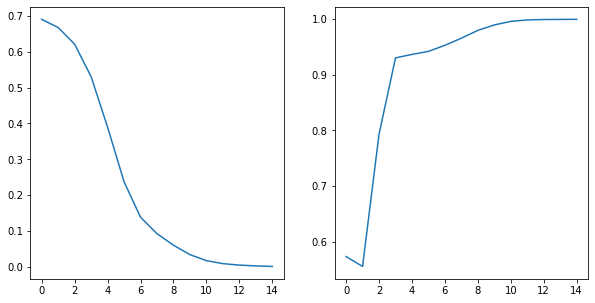

In [68]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(10,5)

ax[0].plot(progress.history["loss"])

ax[1].plot(progress.history["accuracy"])

plt.show()

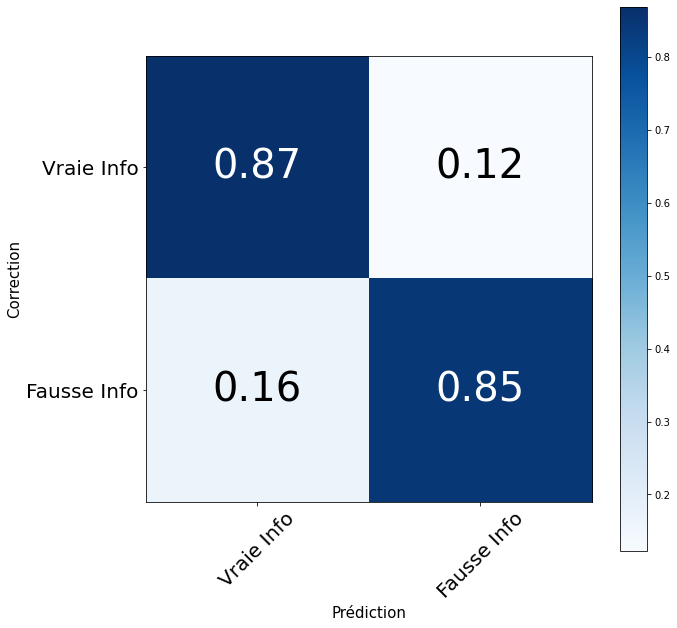

In [69]:
to_predict = pd.concat([dataframe2,dataframe1])

X_test = to_predict["text"]
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

Y_test = to_predict["label"]

threshold = 0.95
predictions = model.predict(X_test)
for i, prediction in enumerate(predictions):
    predictions[i] = 1 if prediction > threshold else 0


cm_plot_labels = ["Vraie Info","Fausse Info"]
cm = confusion_matrix(Y_test, np.round(predictions))
plot_confusion_matrix(cm, cm_plot_labels)

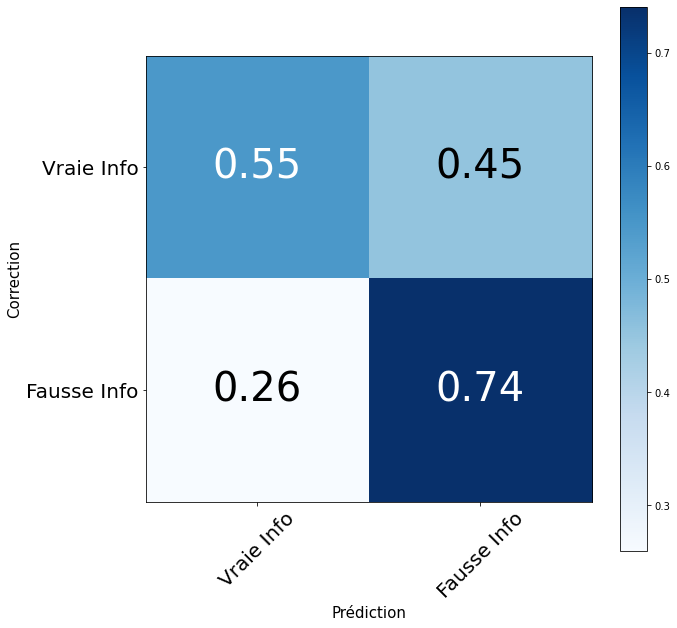

In [70]:
to_predict = pd.concat([dataframe2])

X_test = to_predict["text"]
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

Y_test = to_predict["label"]

threshold = 0.8
predictions = model.predict(X_test)
for i, prediction in enumerate(predictions):
    if prediction > threshold:
        predictions[i] = 1
    else: 
        predictions[i] = 0

cm2 = confusion_matrix(Y_test, predictions)
plot_confusion_matrix(cm2, cm_plot_labels)